# ===========================================================
# Analysis of the Jeopardy-like dataset
# ===========================================================

## Goals:
####   1. Putting the data into a good format (DataFrame or Proto) to facilitate further analysis
####   2. Analysis of the dynamics of appraisal networks and commuincations

#### Last update: 27 Nov 2019

# Imports

In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import heapq
import imp
import networkx as nx
from collections import defaultdict
import sys
sys.path.insert(0, '../src/')
%matplotlib inline

# import Softmax_Loss
import text_processor
import pogs_jeopardy_log_lib
import broadcast_network_extraction
import utils
from mytools import Timer

/home/omid/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/omid/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def reload():
    imp.reload(pogs_jeopardy_log_lib)
    imp.reload(text_processor)
    imp.reload(utils)
    imp.reload(broadcast_network_extraction)

In [3]:
reload()

# Parameters

In [4]:
directory = '/home/omid/Datasets/Jeopardy/'

# Helper functions

In [5]:
def plot_for_one_member(member):
    plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(231)
    number_of_messages_over_time = []
    for i in range(9):
        number_of_messages_over_time.append(np.mean(number_of_messages[member][5*i:5*(i+1)]))
    plt.plot(number_of_messages_over_time)
    plt.title('Number of messages.')

    plt.subplot(232)
    sentiment_of_messages_over_time = []
    for i in range(1, 10):
        sents = np.array(sentiment_of_messages[member][5*i:5*(i+1)])
        sentiment_of_messages_over_time.append(np.mean(sents[~np.isnan(sents)]))
    plt.plot(sentiment_of_messages_over_time)
    plt.title('Sentiment of messages.')

    plt.subplot(233)
    valence_of_messages_over_time = []
    for i in range(1, 10):
        tmps = np.array(emotion_valence_of_messages[member][5*i:5*(i+1)])
        valence_of_messages_over_time.append(np.mean(tmps[~np.isnan(tmps)]))
    plt.plot(valence_of_messages_over_time)
    plt.title('Valence of messages.')

    plt.subplot(234)
    arousal_of_messages_over_time = []
    for i in range(1, 10):
        tmps = np.array(emotion_arousal_of_messages[member][5*i:5*(i+1)])
        arousal_of_messages_over_time.append(np.mean(tmps[~np.isnan(tmps)]))
    plt.plot(arousal_of_messages_over_time)
    plt.title('Arousal of messages.')

    plt.subplot(235)
    dominance_of_messages_over_time = []
    for i in range(1, 10):
        tmps = np.array(emotion_dominance_of_messages[member][5*i:5*(i+1)])
        dominance_of_messages_over_time.append(np.mean(tmps[~np.isnan(tmps)]))
    plt.plot(dominance_of_messages_over_time)
    plt.title('Dominance of messages.');

In [6]:
def plot_influence_dynamics(team_info):
    # Dynamics of the opinion i w.r.t. j:
    plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    index = 221
    tickers = ['p', 'o', '*', '^']
    for i in range(4):
        plt.subplot(221 + i)
        for j in range(4):
            dynamics_of_opinion_i_of_j = np.array(team_info.member_influences)[:, i][:, j]
            plt.plot(dynamics_of_opinion_i_of_j, '-'+tickers[j])
        plt.legend([1, 2, 3, 4])
        plt.title('Member {}\'s opinion dynamics from members.'.format(i+1));

In [7]:
# data = utils.load_it(directory+'Teams_logs.pk', verbose=True) 

# Loading teams' logs

In [8]:
with Timer():
    teams = pd.read_csv(
        directory+"team.csv",
        sep=',',
        quotechar="|",
        names=["id","sessionId","roundId", "taskId"])
    data = {}
    for team_id in teams.id:
        print("Processing team", team_id, '...')
        try:
            data[team_id] = pogs_jeopardy_log_lib.TeamLogProcessor(
                team_id=team_id, logs_directory_path=directory)
        except pogs_jeopardy_log_lib.EventLogsNotLoadedError as e:
            print('Team {} is not found in the logs. There is nothing we can do.'.format(team_id))
            continue
        except Exception as e2:
            print('Team {} had some problems. Check.'.format(team_id))
            continue

Processing team 7 ...


../src/pogs_jeopardy_log_lib.py:385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  event_log_no_message["sender_subject_id"] = pd.to_numeric(event_log_no_message["sender_subject_id"])


Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 35 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 50 ...
Team 50 is not found in the logs. There is nothing we can do.
Processing team 54 ...
Team 54 is not found in the logs. There is nothing we can do.
Processing team 61 ...
Te

In [10]:
print(len(data))
data.keys()

49


dict_keys([7, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 70, 71, 72, 73, 74, 75, 77, 79, 82, 84, 85, 87, 88])

In [11]:
utils.save_it(data, directory+'Teams_logs.pk', verbose=True)

/home/omid/Datasets/Jeopardy/Teams_logs.pk is successfully saved.


In [12]:
data[11].messages[0]

,id,event_type,event_content,timestamp,completed_task_id,sender_subject_id,receiver_subject_id,session_id,sender,receiver,extra_data,team_id
819,3677,COMMUNICATION_MESSAGE,agree on radio waves?,2019-05-13 10:40:15,52,29,\N,6,pogs5.1,\N,\N,11
821,3679,COMMUNICATION_MESSAGE,yes,2019-05-13 10:40:18,52,30,\N,6,pogs5.2,\N,\N,11
822,3680,COMMUNICATION_MESSAGE,yess,2019-05-13 10:40:18,52,32,\N,6,pogs5.4,\N,\N,11
824,3682,COMMUNICATION_MESSAGE,yeah,2019-05-13 10:40:19,52,31,\N,6,pogs5.3,\N,\N,11


# Extracting different networks

In [19]:
messages = data[11].messages[0]

In [14]:
net_extractor = broadcast_network_extraction.NetworkExtraction()

In [26]:
unweighted_directed_graph = net_extractor.extract_network_from_broadcast(
    communication_data=messages,
    time_window=[1, 10],
    weight_type=broadcast_network_extraction.WeightType.NONE,
    aggregation_type=broadcast_network_extraction.AggregationType.BINARY,
    column_names=broadcast_network_extraction.ColumnNameOptions(),
    gamma=0.1)

In [25]:
unweighted_directed_graph.nodes()

NodeView((32, 29, 30, 31))

In [24]:
nx.adj_matrix(unweighted_directed_graph).todense()

matrix([[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 1, 1, 0]], dtype=int64)

In [27]:
sentiment_directed_graph = net_extractor.extract_network_from_broadcast(
    communication_data=messages,
    time_window=[1, 10],
    weight_type=broadcast_network_extraction.WeightType.SENTIMENT,
    aggregation_type=broadcast_network_extraction.AggregationType.AVERAGE,
    column_names=broadcast_network_extraction.ColumnNameOptions(),
    gamma=0.1)

In [28]:
nx.adj_matrix(sentiment_directed_graph).todense()

matrix([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.4019, 0.    , 0.    ],
        [0.296 , 0.296 , 0.296 , 0.    ]])

# Appraisal matrices analysis

In [9]:
final_team_score = []
for team_id, team_data in data.items():
    if 45 in team_data.accumulated_score:  # If they answer all questions.
        heapq.heappush(final_team_score, (team_data.accumulated_score[45], team_id))

In [10]:
low_to_high_performing_teams = []
low_to_high_performing_team_scores = []
while final_team_score:
    (team_score, team_id) = heapq.heappop(final_team_score)
    low_to_high_performing_teams.append(team_id)
    low_to_high_performing_team_scores.append(team_score)

In [17]:
len(low_to_high_performing_teams)

31

Team 34
Team 42
Team 30
Team 12
Team 85
Team 88
Team 10
Team 20
Team 74
Team 84
Team 87
Team 11
Team 13
Team 28
Team 33
Team 17
Team 75
Team 82
Team 38
Team 21
Team 39
Team 48
Team 43
Team 77
Team 41
Team 44
Team 37
Team 45
Team 47
Team 36
Team 49


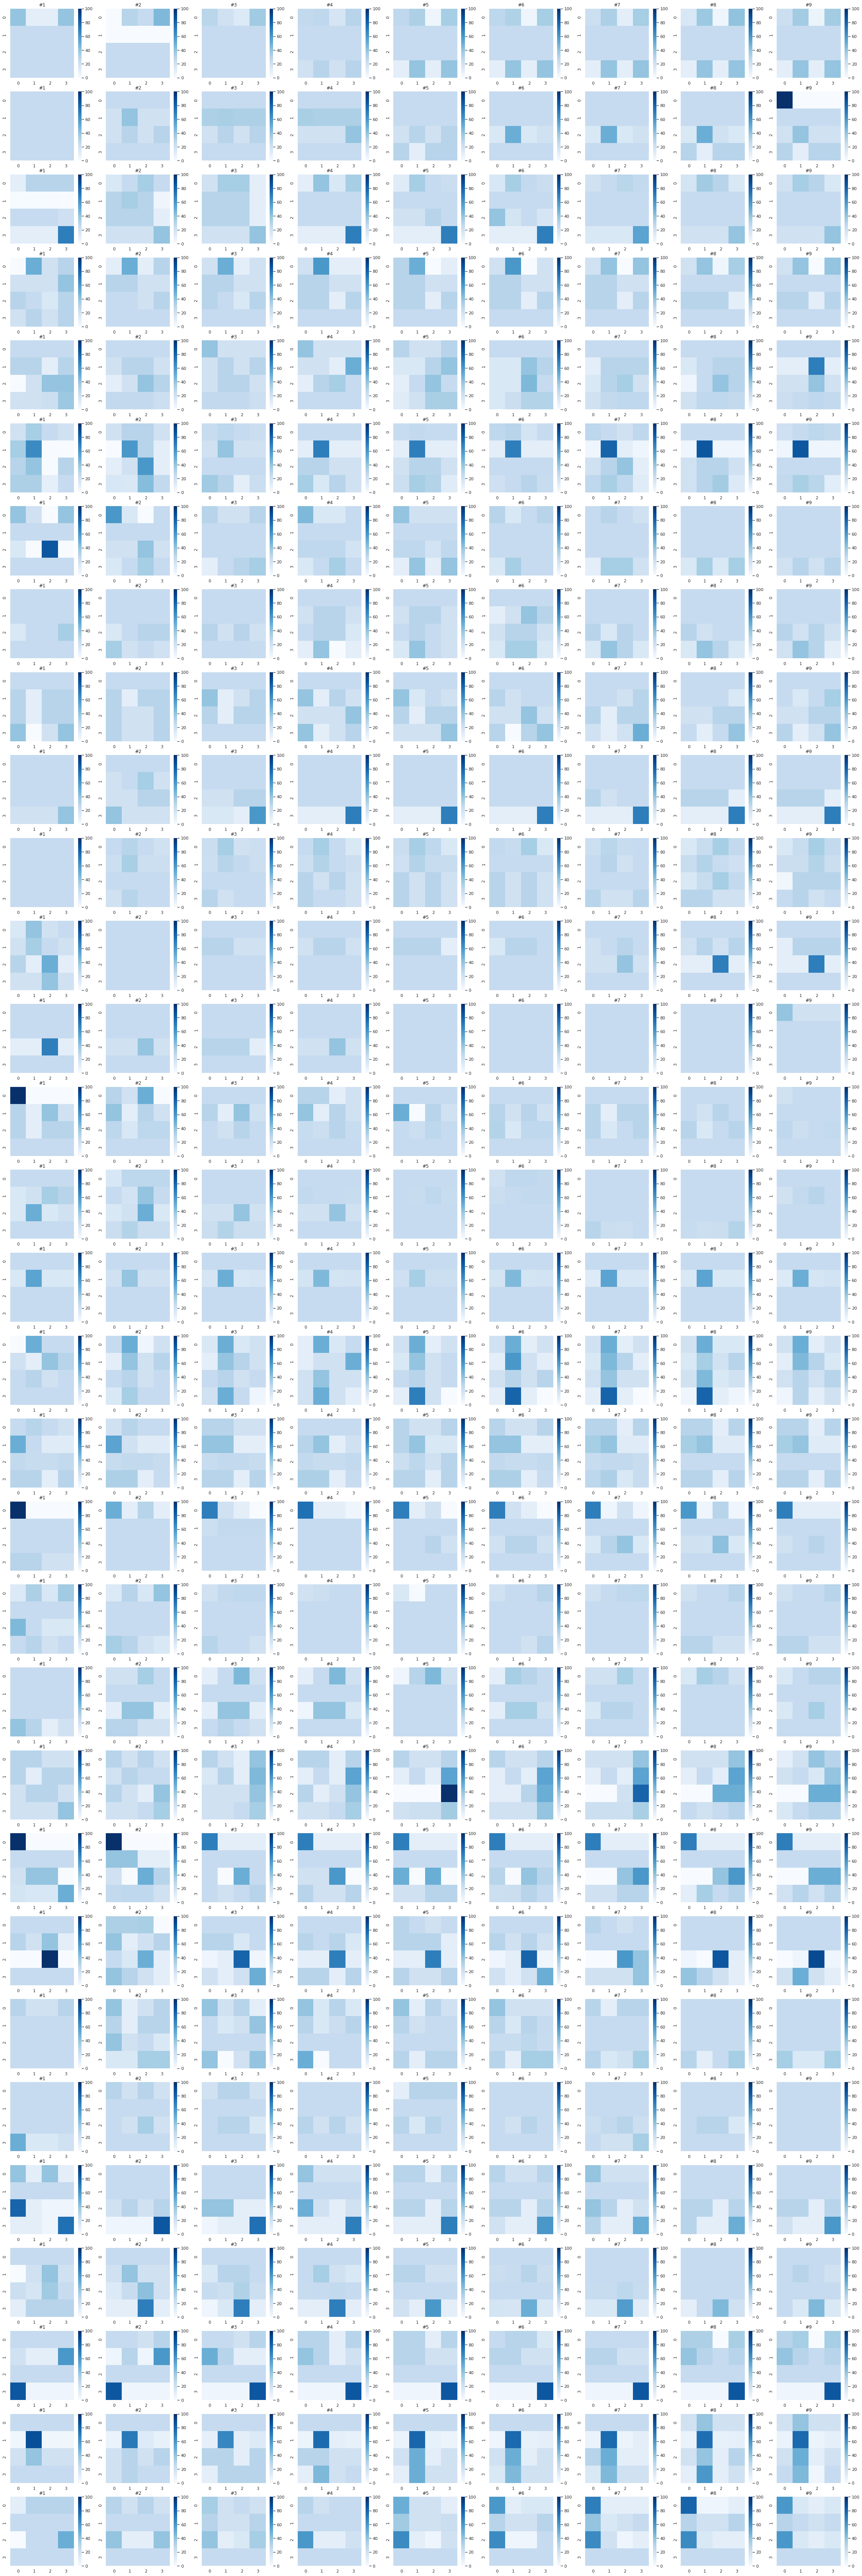

In [22]:
teams_cnt = len(low_to_high_performing_teams)
sns.set(rc={'figure.figsize': (40, 4 * teams_cnt)})
c = 1
# while final_team_score:
#     (_, team_id) = heapq.heappop(final_team_score)
for team_id in low_to_high_performing_teams:
    print('Team {}'.format(team_id))
    team_data = data[team_id]
    for i in range(len(team_data.member_influences)):
        plt.subplot(teams_cnt, 9, c)
        c += 1
        sns.heatmap(team_data.member_influences[i], vmin=0, vmax=100, cmap='Blues')
        plt.title('#{}'.format(i + 1))
# Sorted in rows from the worst to the best performing team.

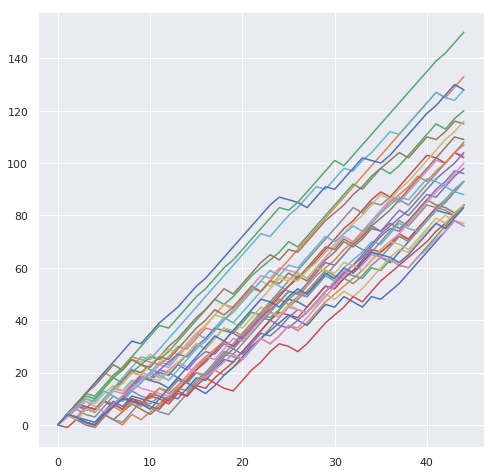

In [151]:
sns.set(rc={'figure.figsize': (8, 8)})
final_scores = []
for team_id, team_info in data.items():
    if 45 in team_info.accumulated_score:
        plt.plot([team_info.accumulated_score[i] for i in range(45)])
        final_scores.append(team_info.accumulated_score[45])

## Bad performing teams

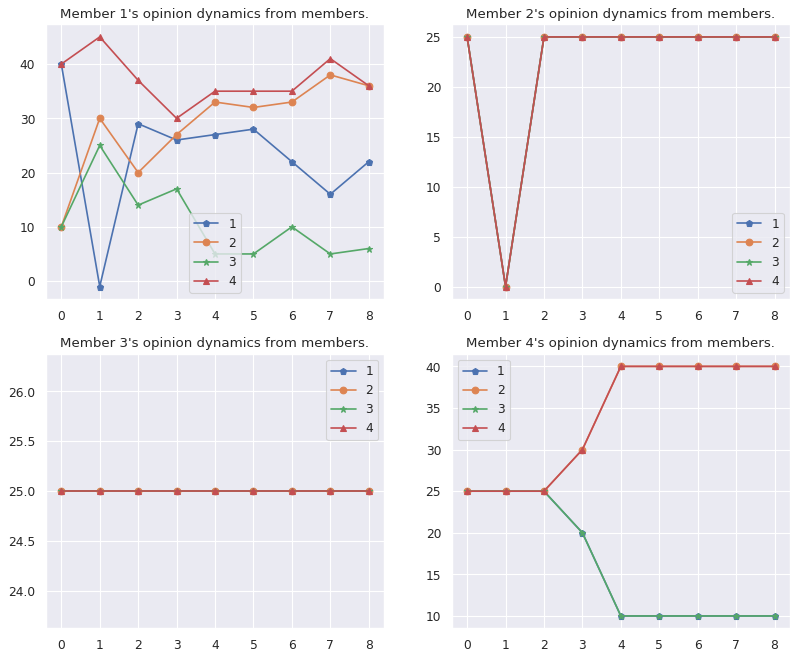

In [27]:
plot_influence_dynamics(data[low_to_high_performing_teams[0]])

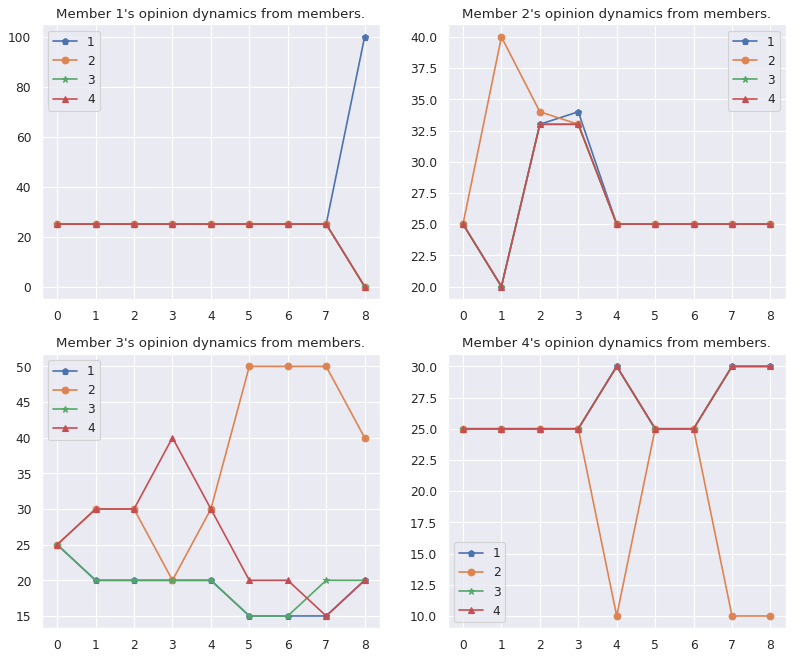

In [28]:
plot_influence_dynamics(data[low_to_high_performing_teams[1]])

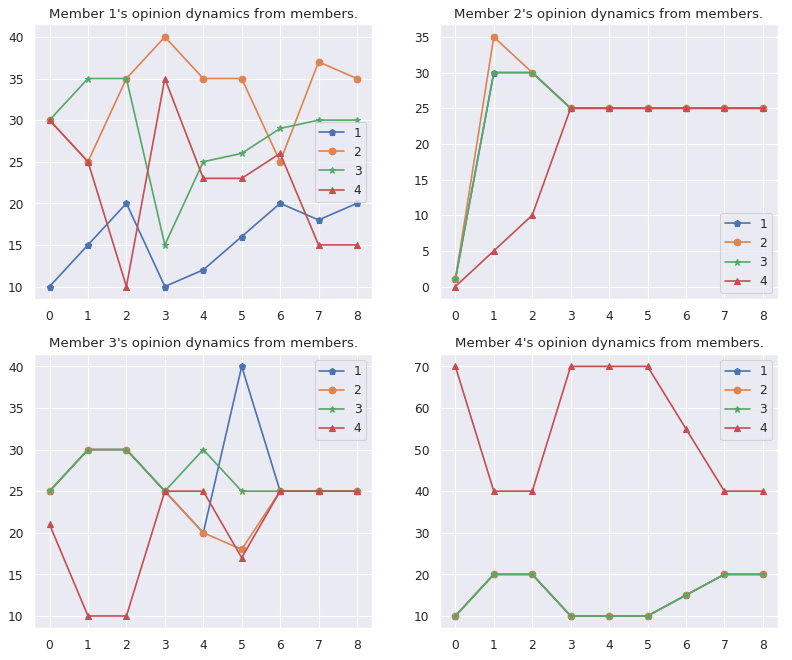

In [29]:
plot_influence_dynamics(data[low_to_high_performing_teams[2]])

# Well performing teams

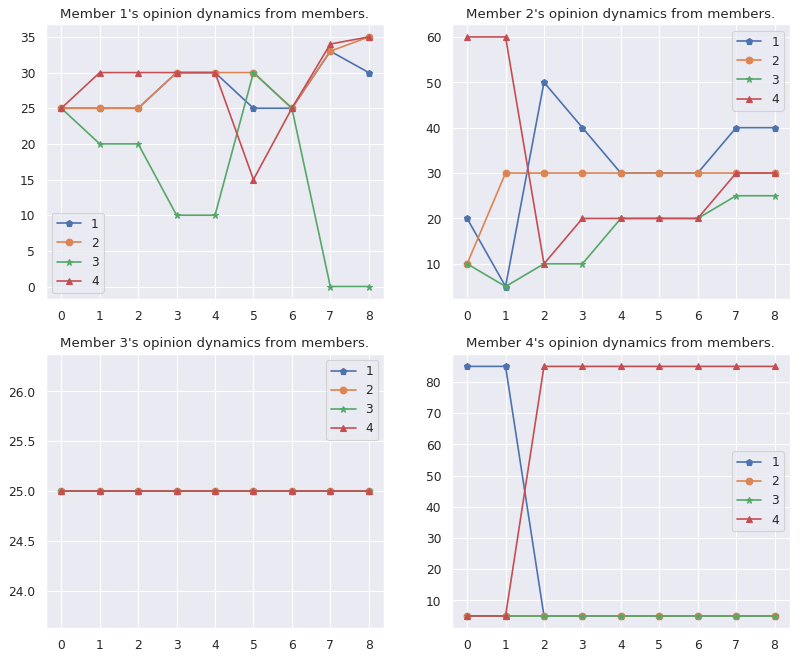

In [30]:
plot_influence_dynamics(data[low_to_high_performing_teams[-3]])

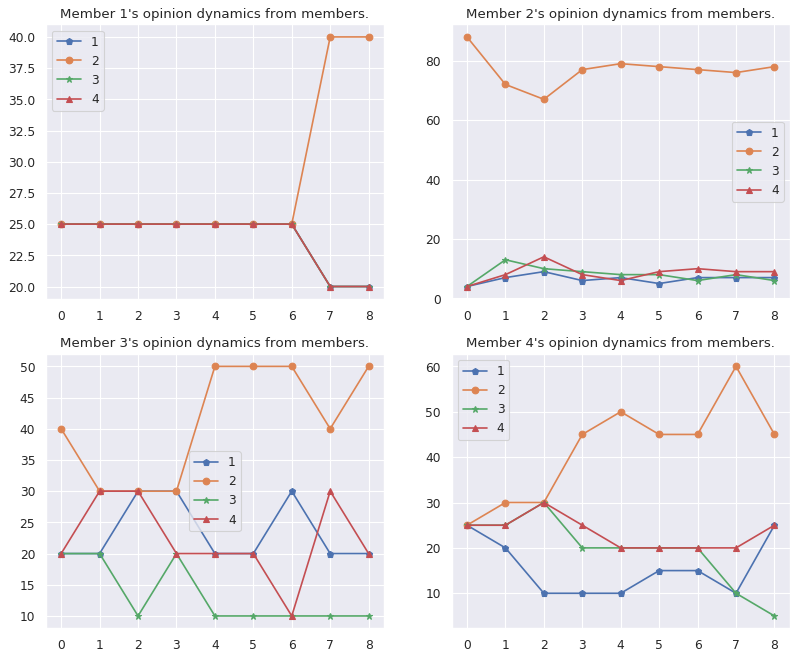

In [31]:
plot_influence_dynamics(data[low_to_high_performing_teams[-2]])

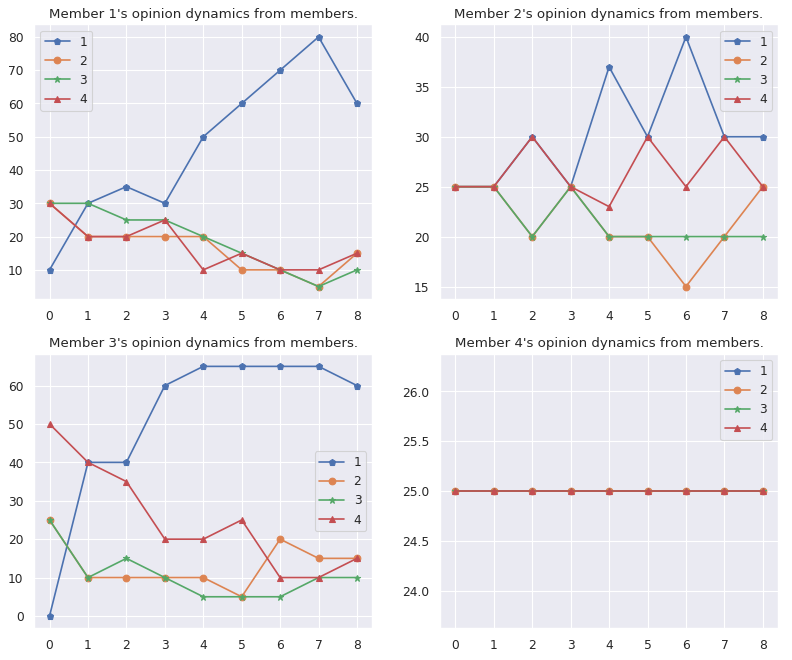

In [32]:
plot_influence_dynamics(data[low_to_high_performing_teams[-1]])

### Find people's individual correctness (in each category).
### Then, find whether people give high appraise to skillfull individuals or not.